In [1]:
import numpy as np
import matplotlib.pyplot as plt

from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import speedy_physics as radiation_jl

import sys
sys.path.append("models/speedy_physics.f90/src")
from shortwave_radiation import radiation as radiation_f90

In [2]:
def compare(func_f, func_jl, func_data, name=None, plot_all=False):
    
    if type(func_data) is tuple and len(func_data) == 2:
        func_data_f, func_data_jl = func_data
    else:
        func_data_f, func_data_jl = func_data, func_data
     
    outs_f = func_f(*func_data_f)
    outs_jl = func_jl(*func_data_jl)
    
    assert type(outs_f) == type(outs_jl)
    if type(outs_f) is tuple:
        iter_n = range(0, len(outs_f))
    else:
        iter_n = [0]
        outs_f = (outs_f, None)
        outs_jl = (outs_jl, None)   
    
    valid_diffs = []
    for i in iter_n:
        try:
            np.testing.assert_allclose(outs_f[i], outs_jl[i], rtol=1e-06, atol=1e-4)
        except:
            print("Difference is high, please check the plot below:")
            plt.boxplot([outs_f[i] - outs_jl[i]])
            plt.show()
        diff = np.array(outs_f[i] - outs_jl[i]).flatten()
        valid_diffs.append(diff)
    # Only plot the summary if there are valid diffs
    if valid_diffs and plot_all:
        print("Summary plot")
        plt.boxplot(valid_diffs)
        plt.ylabel('Difference (Fortran output - Julia output)')
        plt.xlabel('Return variable')
        if name:
            plt.title(f"Fortran <{name}> vs Julia <{name}>")

Summary plot


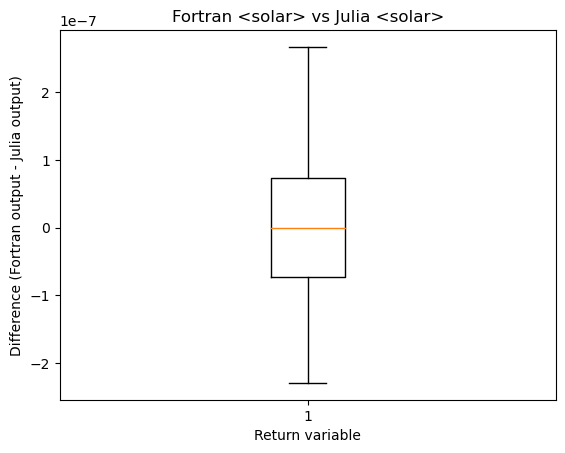

In [3]:
tyear = 0.5
csol = 6.
lats = np.linspace(-89.9, 89.9, 100)
solar_data = tyear, csol, lats

compare(radiation_f90.solar, radiation_jl.solar, solar_data, name="solar", plot_all=True)

Summary plot


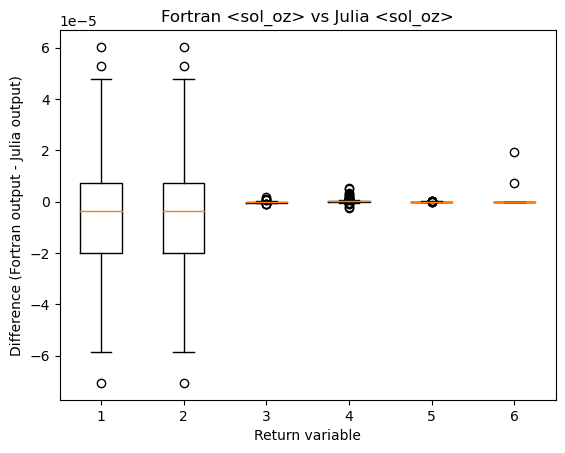

In [4]:
tyear = 0.5
nlon = 1
lats = np.linspace(-89.9, 89.9, 100)
sol_oz_data = tyear, nlon, lats

compare(radiation_f90.sol_oz, radiation_jl.sol_oz, sol_oz_data, name="sol_oz", plot_all=True)

Summary plot


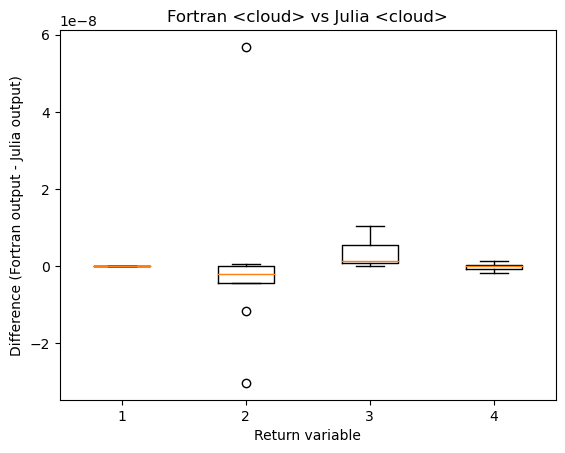

In [5]:
ngp = 10
nlev = 10

prog_q = np.linspace(0.1, 0.000001, ngp*nlev).reshape(ngp, nlev)
rh = np.linspace(0.01, 0.99, ngp*nlev).reshape(ngp, nlev)
cnv_prec = np.full(ngp, 1.)
precls = np.full(ngp, 1.)
cnv_top = np.full(ngp, 1)
gse = np.full(ngp, 1.)
fmask = np.full(ngp, 1.)

cloud_data = (prog_q, rh, cnv_prec, precls, cnv_top, gse, fmask, ngp, nlev)
compare(radiation_f90.cloud, radiation_jl.cloud, cloud_data, name="cloud", plot_all=True)

Summary plot


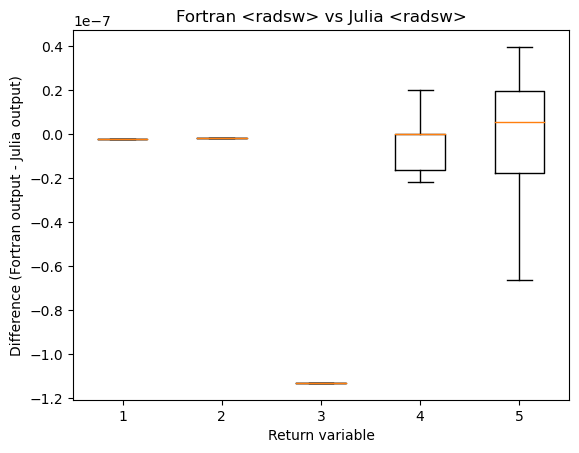

In [6]:
ngp = 1
nlev = 4

prog_sp = np.full(ngp, 1.)
prog_q = np.linspace(0.1, 0.000001, ngp*nlev).reshape(ngp, nlev)
icltop = np.full(ngp, 1)
cloudc = np.full(ngp, 1.)
clstr = np.full(ngp, 1.)
ozupp = np.full(ngp, 1.)
ozone = np.full(ngp, 1.)
zenit = np.full(ngp, 1.)
stratz = np.full(ngp, 1.)
fsol = np.full(ngp, 1.)
qcloud = np.full(ngp, 1.)
albsfc = np.full(ngp, 1.)
sig = np.full(nlev, 1.)
dsig = np.full(nlev, 1.)

# ngp and nlev args have moved to the end and become optionals, check with `?radiation_f90.radsw`
# https://stackoverflow.com/questions/31700558/how-do-i-pass-my-7-3-3-3-array-to-a-fortran-subroutine/31701054#31701054
radsw_data_f = (prog_sp, prog_q, icltop, cloudc, clstr, ozupp, ozone, zenit, stratz, fsol, qcloud, albsfc, sig, dsig, ngp, nlev)
radsw_data_jl = (prog_sp, prog_q, icltop, cloudc, clstr, ozupp, ozone, zenit, stratz, fsol, qcloud, albsfc, ngp, nlev, sig, dsig)
compare(radiation_f90.radsw, radiation_jl.radsw, (radsw_data_f, radsw_data_jl), name="radsw", plot_all=True)

In [7]:
def print_func_io(func, func_data):
    print("Inputs:")
    for i in func_data:
        print(i)
    print("\nOutputs:")
    results = func(*func_data)
    for i in results:
        print(i)

In [8]:
tyear = 0.5
nlon = 1
lats = np.array([89])
func_data = (tyear, nlon, lats)
print_func_io(radiation_f90.sol_oz, func_data)

Inputs:
0.5
1
[89]

Outputs:
[518.2271]
[518.2271]
[6.99611]
[15.666684]
[1.3500085]
[0.]


In [9]:
gp = 1
nlev = 4
prog_q = np.array([0., 0.03124937, 0.9748285, 6.7846994]).reshape(ngp, nlev) # g/kg
rh = np.array([0.0, 1.2526749659224194, 1.3900801817305823, 0.8964701087948754]).reshape(ngp, nlev)
cnv_prec = np.full(ngp, 1.)
precls = np.full(ngp, 1.)
cnv_top = np.full(ngp, 1)
gse = np.full(ngp, 0.4255393541723314)
fmask = np.full(ngp, 1.)
func_data = (prog_q, rh, cnv_prec, precls, cnv_top, gse, fmask, ngp, nlev)

print_func_io(radiation_f90.cloud, func_data)

Inputs:
[[0.         0.03124937 0.9748285  6.7846994 ]]
[[0.         1.25267497 1.39008018 0.89647011]]
[1.]
[1.]
[1]
[0.42553935]
[1.]
1
4

Outputs:
[1]
[1.]
[0.13447052]
[0.9748285]


In [10]:
ngp = 1
nlev = 4

prog_sp = np.full(ngp, 1.)
prog_q = np.array([0., 0.03124937, 0.9748285, 6.7846994]).reshape(ngp, nlev)
albsfc = np.full(ngp, 0.5)
# Same as returned from sol_oz and cloud
icltop = np.full(ngp, 1)
cloudc = np.full(ngp, 0.90186596)
clstr = np.full(ngp, 0.1485)
ozupp = np.full(ngp, 6.99611021887365)
ozone = np.full(ngp, 15.666684)
zenit = np.full(ngp, 1.3500085311452612)
stratz = np.full(ngp, 0.)
fsol = np.full(ngp, 518.2271117159975)
qcloud = np.full(ngp, 0.033334)
sig = np.array([0.08088843, 0.2851103, 0.5810914, 0.87686956])
dsig = np.array([0.16177686, 0.24666686, 0.34529534, 0.24626094])

func_data = (prog_sp, prog_q, icltop, cloudc, clstr, ozupp, ozone, zenit, stratz, fsol, qcloud, albsfc, sig, dsig, ngp, nlev)

print_func_io(radiation_f90.radsw, func_data)

Inputs:
[1.]
[[0.         0.03124937 0.9748285  6.7846994 ]]
[1]
[0.90186596]
[0.1485]
[6.99611022]
[15.666684]
[1.35000853]
[0.]
[518.22711172]
[0.033334]
[0.5]
[0.08088843 0.2851103  0.5810914  0.87686956]
[0.16177686 0.24666686 0.34529534 0.24626094]
1
4

Outputs:
[385.7997]
[192.89986]
[315.10016]
[[[9.5262587e-01 3.7883249e-01 1.0000000e+00 1.0000000e+00]
  [9.2867166e-01 2.2763741e-01 9.9461877e-01 6.8017226e-01]
  [2.1482639e-02 1.2596236e-01 7.9007882e-01 4.9061715e-08]
  [9.2878473e-01 2.2819251e-01 3.1050214e-01 5.2347520e-37]]]
[[11.947815 27.611649 42.56526  40.463364]]
